In [ ]:
!pip install matplotlib scipy pybullet

In [102]:
import pybullet as p
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize

def cost(traj):
    sz = len(traj)
    l2 = np.sqrt(np.sum(traj ** 2 / sz))
    linf = np.max(np.abs(traj))
    return (l2, linf)

def symplectic_euler(func, x0, t):
    x = np.zeros((len(t), len(x0)))
    x[0] = x0
    for i in range(1, len(t)):
        h = t[i] - t[i - 1]
        q_prev, p_prev = x[i - 1]
        p_next = p_prev + h * func([q_prev, p_prev], 0)[1]
        q_next = q_prev + h * p_next
        x[i] = [q_next, p_next]
    return x

def symplectic_euler_param(func, x0, t, a):
    x = np.zeros((len(t), len(x0)))
    x[0] = x0
    for i in range(1, len(t)):
        h = t[i] - t[i - 1]
        q_prev, p_prev = x[i - 1]
        p_next = p_prev + h * func([q_prev, p_prev], 0, a)[1]
        q_next = q_prev + h * p_next
        x[i] = [q_next, p_next]
    return x

init k: [18, 1, 1]
l2_res: 4.8092641390812416e-05
k: [1.81693483 8.30798895 6.20535822]


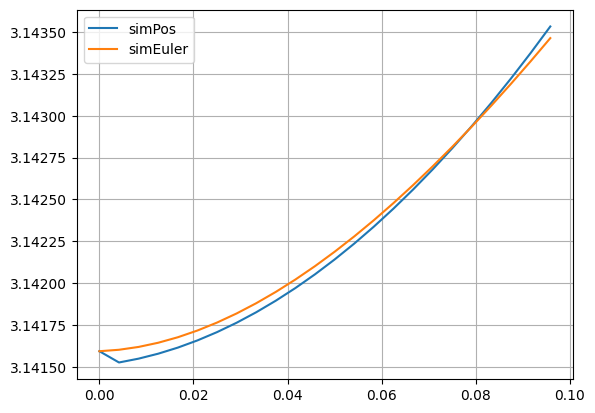

In [105]:
g = 10
L = 0.5
damp = 0.5
damp_coeff = 4.00030788 # if damp = 0.5
damp_lin_coeff = 4.02392125 # if damp = 0.5
torque = 0.1
force = 0.40000977 # if torque = 0.1
force_lin = 0.40185555 # if torque = 0.1
dt = 1/240 # pybullet simulation step
q0 = np.pi # np.deg2rad(15)   # starting position (radian)
jIdx = 1
maxTime = 0.1 # 5
logTime = np.arange(0.0, maxTime, dt)
sz = len(logTime)
logPos = np.zeros(sz)
logPos[0] = q0
idx = 0

physicsClient = p.connect(p.DIRECT) # or p.DIRECT for non-graphical version
p.setGravity(0,0,-10)
boxId = p.loadURDF("./pendulum.urdf", useFixedBase=True)

# turn off internal damping
p.changeDynamics(boxId, 1, linearDamping=0, angularDamping=0)

# go to the starting position
p.setJointMotorControl2(bodyIndex=boxId, jointIndex=jIdx, targetPosition=q0, controlMode=p.POSITION_CONTROL)
for _ in range(100):
    p.stepSimulation()

# turn off the motor for the free motion
p.setJointMotorControl2(bodyIndex=boxId, jointIndex=jIdx, targetVelocity=0, controlMode=p.VELOCITY_CONTROL, force=0)
for t in logTime[1:]:
    p.setJointMotorControl2(bodyIndex=boxId, jointIndex=jIdx, controlMode=p.TORQUE_CONTROL, force=0.1)
    p.stepSimulation()

    jointState = p.getJointState(boxId, jIdx)
    th1 = jointState[0]
    idx += 1
    logPos[idx] = th1

def rp(x, t):
    return [x[1],
            -g/L*np.sin(x[0]) - damp*damp_coeff*x[1] + force]

def rp_lin(x, t):
    return [x[1],
            -g/L*x[0] - damp*damp_lin_coeff*x[1] + force_lin]

def rp_param(x, t, a):
    return [x[1],
            -a*np.sin(x[0])]

def rp_param_demp(x, t, k):
    return [x[1],
            -g/L*np.sin(x[0]) - damp*k*x[1]]

def rp_lin_param_demp(x, t, k):
    return [x[1],
            -g/L*x[0] - damp*k*x[1]]

def rp_param_torque(x, t, force):
    return [x[1],
            -g/L*np.sin(x[0]) - damp*damp_coeff*x[1] + force]

def rp_lin_param_torque(x, t, force):
    return [x[1],
            -g/L*x[0] - damp*damp_coeff*x[1] + force]

def rp_param_general(x, t, list_params):
  return [x[1],
          -list_params[0]*np.sin(x[0]) - list_params[1]*x[1] + list_params[2]]

def rp_lin_param_general(x, t, list_params):
  return [x[1],
          -list_params[0]*x[0] - list_params[1]*x[1] + list_params[2]]

# theta = odeint(rp, [q0, 0], logTime)
# logTheor = theta[:,0]

# (l2, linf) = cost(logPos - logTheor)
# print(l2, linf)

# theta = symplectic_euler(rp, [q0, 0], logTime)
# logEuler = theta[:, 0]

# (l2, linf) = cost(logPos - logEuler)
# print(l2, linf)

# thetaLin = symplectic_euler(rp_lin, [q0, 0], logTime)
# logLin = thetaLin[:, 0]

def l2_cost(a):
    xx = symplectic_euler_param(rp_lin_param_general, [q0, 0], logTime, a)
    return cost(logPos-xx[:,0])[0]

def get_l2_optim_param(func, list_params):
  """
  input: list_params = [a - coeff before sinus,
                        k - coeff before dtheta,
                        f - force]
  return: list of optimal parameters
  """
  return minimize(l2_cost, list_params)

k0 = [18, 1, 1]
print(f'init k: {k0}')
# res = minimize(l2_cost_torque, k0)
res = get_l2_optim_param(rp_lin_param_general, k0)
print(f'l2_res: {res.fun}')
print(f'k: {res.x}')

theta = symplectic_euler_param(rp_lin_param_general, [q0, 0], logTime, res.x)
logEuler = theta[:, 0]

# a0 = [0.9*g/L]
# print(f'init a: {a0}')
# res = minimize(l2_cost, a0)
# print(f'l2_res: {res.fun}')
# print(f'a: {res.x}')
# print(f'a_th: {g/L}')
# a = res.x[0]

import matplotlib.pyplot as plt

plt.grid(True)
plt.plot(logTime, logPos, label = "simPos")
# plt.plot(logTime, logTheor, label = "simTheor")
plt.plot(logTime, logEuler, label = "simEuler")
# plt.plot(logTime, logLin, label = "logLin")
plt.legend()

plt.show()

p.disconnect()

# 1 add damping to rp and rp_lin
# 2 add control torque to rp and rp_lin
# 3 widen minimize to estimate a, damping coef and toqrue coef
# 4 derive linear model from upper position and compare to sim (compare first 0.1 sec)